In [6]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Heiti TC'] if sys.platform == 'darwin' else ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [7]:
import numpy as np
from scipy.stats import norm
 
 
class GREEK(object):
    def __init__(self, S=None, K=None, vol=None, T=None, r=None, direction=None):
        self.T = T or 1  # 到期期限，默认值为1
        self.S = S or 10  # 标的价格，默认值为10
        self.K = K or 10  # 执行价，默认值为10
        self.r = r or 0.03  # 无风险利率，默认值为3%
        self.vol = vol or 0.2  # 波动率，默认值为20%
        self.dir = direction or 'call'  # 期权方向，默认值为call-看涨
        # 衍生的基础数据
        self.vol_T = self.vol * np.sqrt(self.T)  # 波动率乘根号下的到期期限
        self.d1 = (np.log(self.S / self.K) + (self.r + self.vol ** 2 / 2) * self.T) / self.vol_T  # d1的值
        self.d2 = self.d1 - self.vol_T  # d2的值
        self.N_d1 = norm.cdf(self.d1)  # N(d1)的值
        self.N_d1_diff = norm.pdf(self.d1)  # N(d1)的求导值
        self.N_d2 = norm.cdf(self.d2)  # N(d2)的值
 
    def Price(self):
        # BSM计算期权的价格
        part = self.K * np.exp(-self.r * self.T)
        if self.dir == 'call':
            price_value = self.S * self.N_d1 - part * self.N_d2
        else:
            price_value = part * (1 - self.N_d2) - self.S * (1 - self.N_d1)
        return price_value
 
    def Delta(self):
        # 计算Delta的值
        if self.dir == 'call':
            delta_value = self.N_d1
        else:
            delta_value = self.N_d1-1
        return delta_value
 
    def Gamma(self):
        # 计算Gamma的值
        return self.N_d1_diff / (self.S * self.vol_T)
 
    def Vega(self):
        # 计算Vega的值
        return self.S * self.N_d1_diff * np.sqrt(self.T)
 
    def Theta(self):
        # 计算Theta的值
        one_part = -self.S * self.N_d1_diff * self.vol / (2 * np.sqrt(self.T))
        other_part = self.r * self.K * np.exp(-self.r * self.T) * self.N_d2
        if self.dir == 'call':
            theta_value = one_part - other_part
        else:
            theta_value = one_part + other_part
        return theta_value
 
    def Rho(self):
        # 计算Rho的值
        # 计算Rho的值
        part = self.K * self.T * np.exp(-self.r * self.T)
        if self.dir == 'call':
            rho_value = part * self.N_d2
        else:
            rho_value = -part * (1 - self.N_d2)
        return rho_value

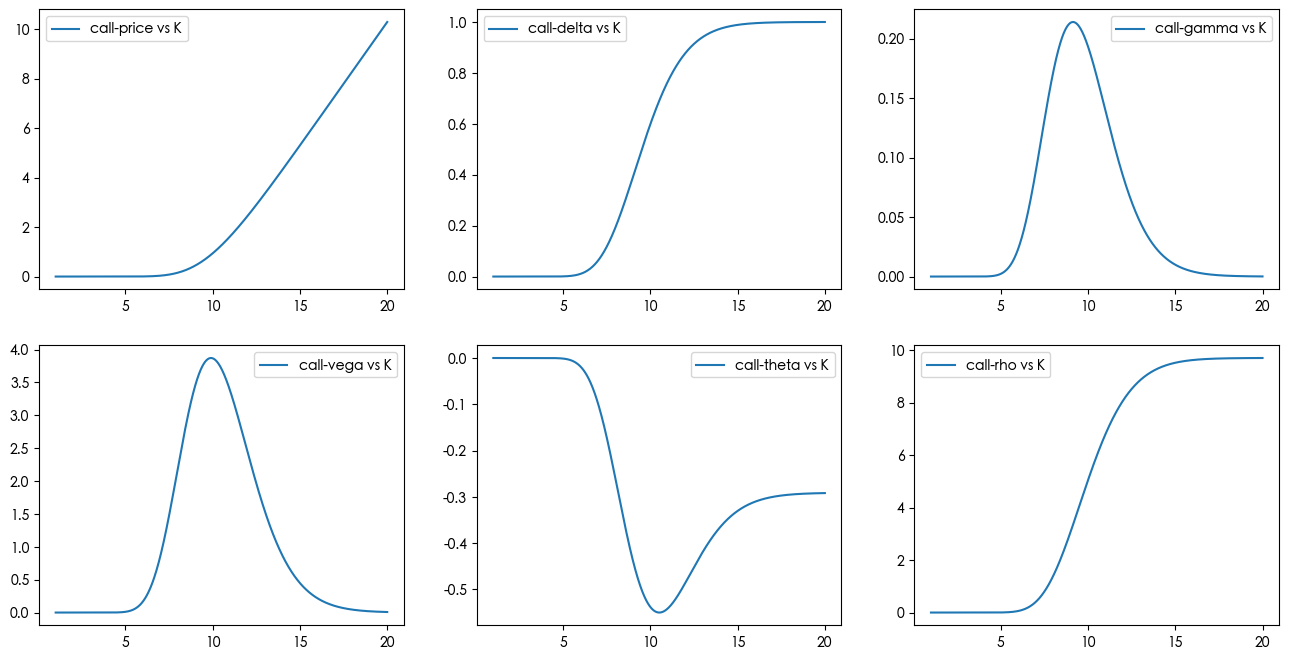

In [19]:
import numpy as np
import pandas as pd
import sys
 
 
def get_greek_value(S_list, direction):
    data_list = []
    for value in S_list:
        S = round(value, 2)
        price = GREEK(S=S, direction=direction).Price()
        delta = GREEK(S=S, direction=direction).Delta()
        gamma = GREEK(S=S, direction=direction).Gamma()
        vega = GREEK(S=S, direction=direction).Vega()
        theta = GREEK(S=S, direction=direction).Theta()
        rho = GREEK(S=S, direction=direction).Rho()
        data_dict = {'S': S, 'price': price, 'delta': delta, 'gamma': gamma,
                     'vega': vega, 'theta': theta, 'rho': rho}
        data_list.append(data_dict)
    return data_list
 
 

s_list = np.linspace(1, 20, 2000)
direction = 'call'
data = get_greek_value(s_list, direction)
data_df = pd.DataFrame(i for i in data)
name_list = [['price', 'delta', 'gamma'], ['vega', 'theta', 'rho']]  # 分组

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
# 循环作图
for row in range(2):
    for col in range(3):
        name = name_list[row][col]
        ax[row, col].plot(data_df['S'], data_df[name])
        ax[row, col].legend([direction + '-' + name + ' vs K'])
plt.show()

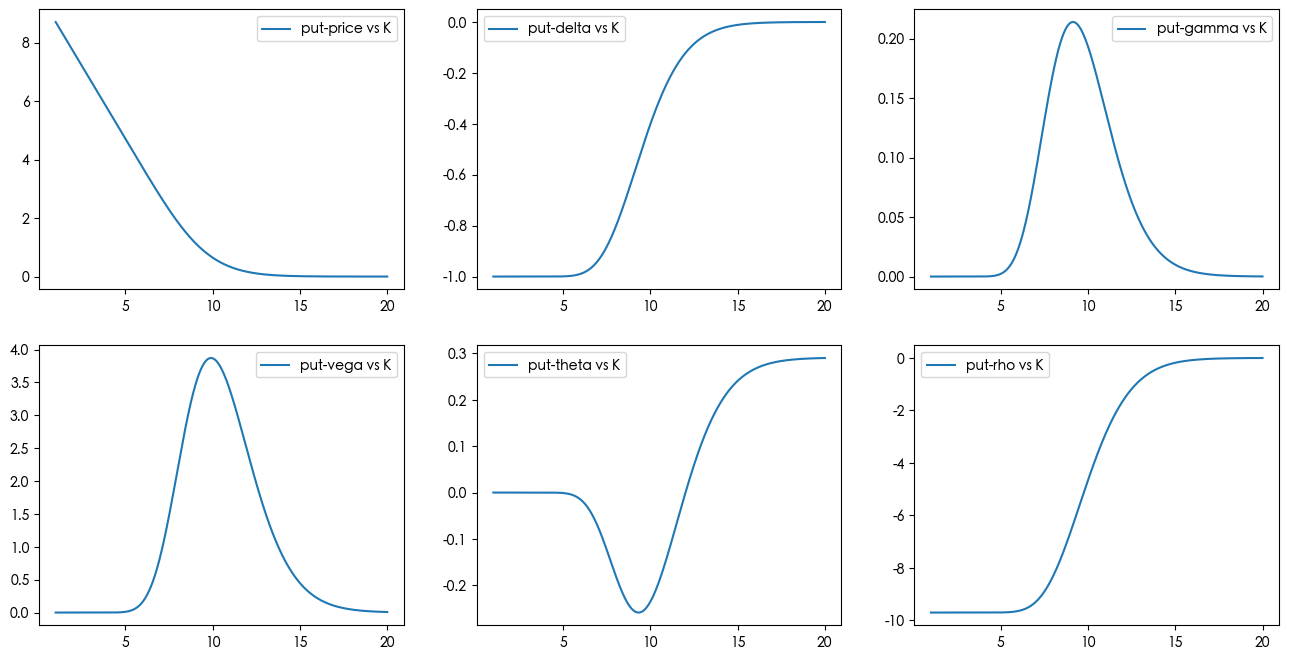

In [20]:
s_list = np.linspace(1, 20, 2000)
direction = 'put'
data = get_greek_value(s_list, direction)
data_df = pd.DataFrame(i for i in data)
name_list = [['price', 'delta', 'gamma'], ['vega', 'theta', 'rho']]  # 分组

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
# 循环作图
for row in range(2):
    for col in range(3):
        name = name_list[row][col]
        ax[row, col].plot(data_df['S'], data_df[name])
        ax[row, col].legend([direction + '-' + name + ' vs K'])
plt.show()

In [14]:
# 针对不同到期日
def get_greek_vs_T(T_list, direction='call', S=10, K=10, vol=0.2, r=0.03):
    data_list = []
    for T in T_list:
        g = GREEK(S=S, K=K, vol=vol, T=T, r=r, direction=direction)
        data_dict = {
            'T': T,
            'price': g.Price(),
            'delta': g.Delta(),
            'gamma': g.Gamma(),
            'vega': g.Vega(),
            'theta': g.Theta(),
            'rho': g.Rho()
        }
        data_list.append(data_dict)
    return pd.DataFrame(data_list)
# 针对不同波动率
def get_greek_vs_vol(vol_list, direction='call', S=10, K=10, T=1, r=0.03):
    data_list = []
    for vol in vol_list:
        g = GREEK(S=S, K=K, vol=vol, T=T, r=r, direction=direction)
        data_dict = {
            'vol': vol,
            'price': g.Price(),
            'delta': g.Delta(),
            'gamma': g.Gamma(),
            'vega': g.Vega(),
            'theta': g.Theta(),
            'rho': g.Rho()
        }
        data_list.append(data_dict)
    return pd.DataFrame(data_list)    

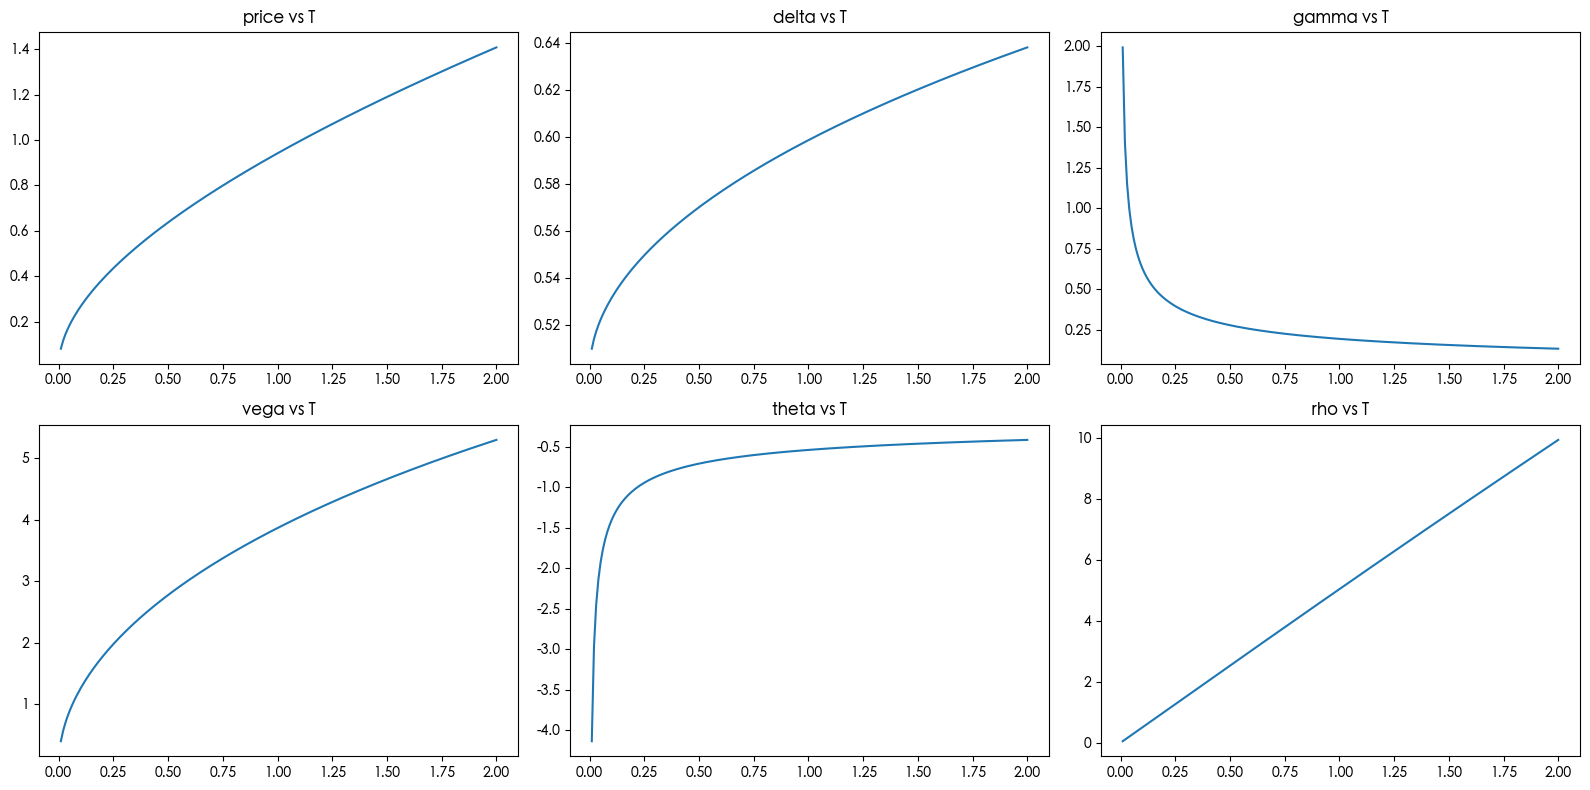

In [16]:
# 到期日曲线
T_list = np.linspace(0.01, 2, 200)
df_T = get_greek_vs_T(T_list)

name_list = [['price', 'delta', 'gamma'], ['vega', 'theta', 'rho']]  # 分组

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for row in range(2):
    for col in range(3):
        name = name_list[row][col]
        ax[row, col].plot(df_T['T'], df_T[name])
        ax[row, col].set_title(f'{name} vs T')
plt.tight_layout()
plt.show()

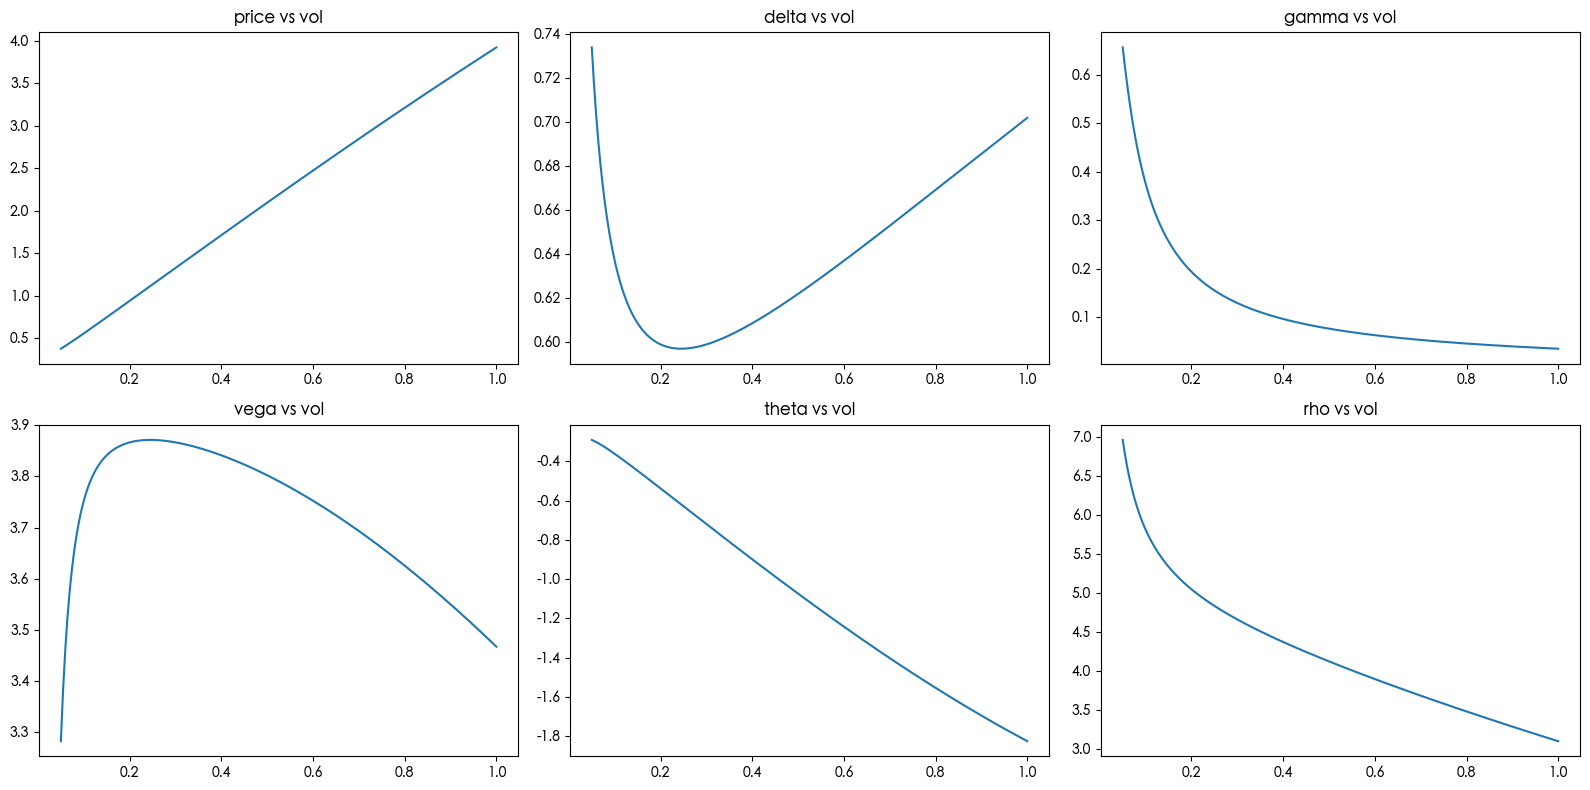

In [17]:
vol_list = np.linspace(0.05, 1.0, 200)
df_vol = get_greek_vs_vol(vol_list)

name_list = [['price', 'delta', 'gamma'], ['vega', 'theta', 'rho']]  # 分组

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
for row in range(2):
    for col in range(3):
        name = name_list[row][col]
        ax[row, col].plot(df_vol['vol'], df_vol[name])
        ax[row, col].set_title(f'{name} vs vol')
plt.tight_layout()
plt.show()

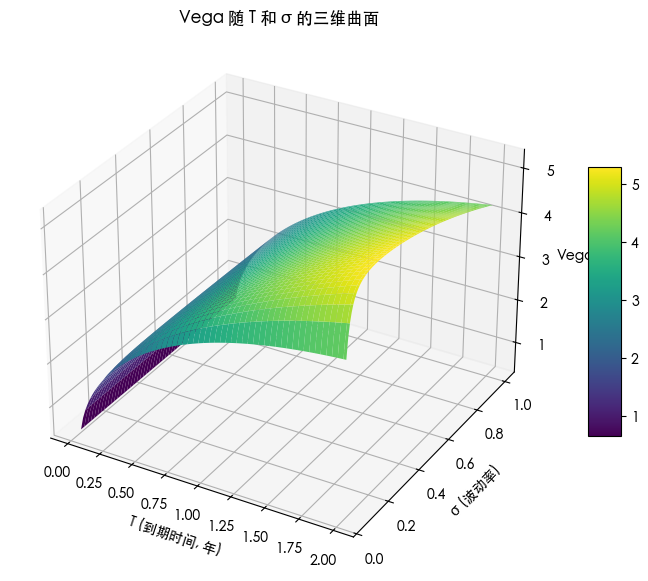

In [21]:
# ----------------------
# 计算 Vega 曲面
# ----------------------
T_list = np.linspace(0.01, 2, 100)     # 到期时间：0.01 ~ 2 年
vol_list = np.linspace(0.05, 1.0, 100) # 波动率：5% ~ 100%

T_grid, vol_grid = np.meshgrid(T_list, vol_list)  # 构造网格
Vega_grid = np.zeros_like(T_grid)

for i in range(T_grid.shape[0]):
    for j in range(T_grid.shape[1]):
        g = GREEK(S=10, K=10, T=T_grid[i, j], vol=vol_grid[i, j])
        Vega_grid[i, j] = g.Vega()

# ----------------------
# 绘制三维曲面
# ----------------------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(T_grid, vol_grid, Vega_grid, cmap='viridis', edgecolor='none')

ax.set_xlabel('T (到期时间, 年)')
ax.set_ylabel('σ (波动率)')
ax.set_zlabel('Vega')
ax.set_title('Vega 随 T 和 σ 的三维曲面')

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()